### script for merging time series of storm types
### over the CONUS in the Bukovsky regions from 1995–2017
### date created: 20 Oct. 2021
### contact: doughert@ucar.edu

In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
from netCDF4 import Dataset, num2date
from datetime import datetime, date, timedelta
import glob
import xarray as xr
import geopandas as gp
#from wrf import getvar, ALL_TIMES

### import df of all different storm types


In [5]:
isolated =  pd.read_csv('Isolated_convection_daily_counts_bukovsky_regions.csv', header=0)
nonconv =  pd.read_csv('non_convective_daily_counts_bukovsky_regions.csv', header=0)
mcs =  pd.read_csv('MCS_daily_counts_bukovsky_regions.csv', header=0)
fronts =  pd.read_csv('/glade/work/doughert/asp/flood_storm_types/frontal_ID/Frontal_daily_counts_bukovsky_regions.csv', header=0)
etc =  pd.read_csv('ETC_daily_counts_bukovsky_regions.csv', header=0)
tc =  pd.read_csv('TC_daily_counts_bukovsky_regions.csv', header=0)

### rename occurence as storm type

In [6]:
isolated  = isolated.rename({'occurrence':'isolated'}, axis=1)
nonconv  = nonconv.rename({'occurrence':'nonconv'}, axis=1)
mcs  = mcs.rename({'occurrence':'mcs'}, axis=1)
fronts  = fronts.rename({'occurrence':'fronts'}, axis=1)
etc['etc']  = (etc['Pmin']>0).astype(int)
etc = etc.rename({'Date':'date'}, axis=1)
etc = etc.rename({'Region':'region'}, axis=1)
tc['tc']  = (tc['Pmin']==1).astype(int)
tc = tc.rename({'Date':'date'}, axis=1)
tc = tc.rename({'Region':'region'}, axis=1)

In [7]:
pd.options.display.max_columns=999
pd.options.display.max_rows=999

#### rename columns regarding intensity and size of storm

In [8]:
isolated = isolated.rename(columns={'avg_dbz':'avg_iso_dbz', 'size (km)':'size_iso'})
nonconv = nonconv.rename(columns={'avg_dbz':'avg_nonconv_dbz', 'size (km)':'size_nonconv'})
mcs = mcs.rename(columns={'avg_dbz':'avg_mcs_dbz', 'size (km)':'size_mcs'})
etc = etc.rename(columns={'Pmin':'etc_Pmin'})
tc = tc.rename(columns={'Pmin':'tc_Pmin'})

#### drop extra columns

In [9]:
isolated = isolated.drop(['Unnamed: 0', 'object_idx', 'max_dbz'],axis=1)
nonconv = nonconv.drop(['Unnamed: 0', 'object_idx', 'max_dbz'],axis=1)
mcs = mcs.drop(['Unnamed: 0', 'object_idx', 'max_dbz'],axis=1)
fronts = fronts.drop(['Unnamed: 0', 'front_y', 'front_x', 'front_xy'],axis=1)
etc = etc.drop(['Unnamed: 0',], axis=1)
tc = tc.drop(['Unnamed: 0', 'Vmax'], axis=1)

In [10]:
conv_merge = isolated.merge(nonconv, on=['date', 'region'], how='right')
rain_merge = conv_merge.merge(mcs, on=['date', 'region'], how='left')
fronts_merge = rain_merge.merge(fronts, on=['date', 'region'], how='right')
etc_merge = fronts_merge.merge(etc, on=['date', 'region'], how='left')
tc_merge = etc_merge.merge(tc, on=['date', 'region'], how='left')

In [11]:
tc_merge = tc_merge.fillna(0)
print(tc_merge)

          region        date  isolated  size_iso  avg_iso_dbz  nonconv  \
0           East  1995-01-01       1.0      13.0    41.199413      1.0   
1         Pac_SW  1995-01-01       0.0       0.0     0.000000      0.0   
2         Pac_NW  1995-01-01       0.0       0.0     0.000000      0.0   
3      MountainW  1995-01-01       0.0       0.0     0.000000      0.0   
4          South  1995-01-01       0.0       0.0     0.000000      0.0   
...          ...         ...       ...       ...          ...      ...   
75617       East  2017-12-31       0.0       0.0     0.000000      1.0   
75618     Pac_NW  2017-12-31       0.0       0.0     0.000000      0.0   
75619         GP  2017-12-31       0.0       0.0     0.000000      1.0   
75620     Desert  2017-12-31       0.0       0.0     0.000000      1.0   
75621      South  2017-12-31       1.0      36.0    42.917598      1.0   

       size_nonconv  avg_nonconv_dbz  mcs  size_mcs  avg_mcs_dbz  fronts  \
0       1146.083333        22.80937

### determine predominant cause of rainfall - see Fig. 2 in Brunner and Dougherty (2022)

In [12]:
storm_type = []
avg_dbz = []
size = []
pmin = []

for i in range(len(tc_merge)):
    # classify TC
    if tc_merge['tc'].iloc[i]==1.0:
        storm_type.append('tc')
        avg_dbz.append(0)
        size.append(0)
        pmin.append(tc_merge['tc_Pmin'].iloc[i])
        
        
    # classify frontal precip
    elif (tc_merge['fronts'].iloc[i]==1.0) and (tc_merge['mcs'].iloc[i]==1.0):
        storm_type.append('frontal mcs')
        avg_dbz.append(tc_merge['avg_mcs_dbz'].iloc[i])
        size.append(tc_merge['size_mcs'].iloc[i])
        pmin.append(0)
        
    elif (tc_merge['fronts'].iloc[i]==1.0) and (tc_merge['isolated'].iloc[i]==1.0) and (tc_merge['mcs'].iloc[i]==0.0):
        storm_type.append('frontal isolated')
        avg_dbz.append(tc_merge['avg_iso_dbz'].iloc[i])
        size.append(tc_merge['size_iso'].iloc[i])
        pmin.append(0)
        
    elif (tc_merge['fronts'].iloc[i]==1.0) and (tc_merge['isolated'].iloc[i]==0.0) and (tc_merge['mcs'].iloc[i]==0.0) and (tc_merge['nonconv'].iloc[i]==1.0):
        storm_type.append('frontal stratiform')
        avg_dbz.append(tc_merge['avg_nonconv_dbz'].iloc[i])
        size.append(tc_merge['size_nonconv'].iloc[i])
        pmin.append(0)
        
        
    # classify fronts w/o precip
    elif (tc_merge['fronts'].iloc[i]==1.0) and (tc_merge['mcs'].iloc[i]==0.0) and (tc_merge['isolated'].iloc[i]==0.0) and (tc_merge['nonconv'].iloc[i]==0.0):
        storm_type.append('front no rain')
        avg_dbz.append(0)
        size.append(0)
        pmin.append(0)
        
        
    # classify etc precip (w/o front since most have fronts)
    elif (tc_merge['etc'].iloc[i]==1.0) and (tc_merge['fronts'].iloc[i]==0.0) and (tc_merge['mcs'].iloc[i]==1.0):
        storm_type.append('etc mcs')
        avg_dbz.append(tc_merge['avg_mcs_dbz'].iloc[i])
        size.append(tc_merge['size_mcs'].iloc[i])
        pmin.append(tc_merge['etc_Pmin'].iloc[i])
        
    elif (tc_merge['etc'].iloc[i]==1.0) and (tc_merge['fronts'].iloc[i]==0.0) and (tc_merge['mcs'].iloc[i]==0.0) and (tc_merge['isolated'].iloc[i]==1.0):
        storm_type.append('etc isolated')
        avg_dbz.append(tc_merge['avg_iso_dbz'].iloc[i])
        size.append(tc_merge['size_iso'].iloc[i])
        pmin.append(tc_merge['etc_Pmin'].iloc[i])
        
    elif (tc_merge['etc'].iloc[i]==1.0) and (tc_merge['fronts'].iloc[i]==0.0) and (tc_merge['mcs'].iloc[i]==0.0) and (tc_merge['isolated'].iloc[i]==0.0) and (tc_merge['nonconv'].iloc[i]==1.0):
        storm_type.append('etc stratiform')
        avg_dbz.append(tc_merge['avg_nonconv_dbz'].iloc[i])
        size.append(tc_merge['size_nonconv'].iloc[i])
        pmin.append(tc_merge['etc_Pmin'].iloc[i])
        
        
      # classify precip w/o fronts
    elif (tc_merge['fronts'].iloc[i]==0.0) and (tc_merge['mcs'].iloc[i]==1.0):
        storm_type.append('non-frontal mcs')
        avg_dbz.append(tc_merge['avg_mcs_dbz'].iloc[i])
        size.append(tc_merge['size_mcs'].iloc[i])
        pmin.append(0)
        
    elif (tc_merge['fronts'].iloc[i]==0.0) and (tc_merge['isolated'].iloc[i]==1.0) and (tc_merge['mcs'].iloc[i]==0.0):
        storm_type.append('non-frontal isolated')   
        avg_dbz.append(tc_merge['avg_iso_dbz'].iloc[i])
        size.append(tc_merge['size_iso'].iloc[i])
        pmin.append(0)
        
    elif (tc_merge['fronts'].iloc[i]==0.0) and (tc_merge['isolated'].iloc[i]==0.0) and (tc_merge['mcs'].iloc[i]==0.0) and (tc_merge['nonconv'].iloc[i]==1.0):
        storm_type.append('non-frontal stratiform')
        avg_dbz.append(tc_merge['avg_nonconv_dbz'].iloc[i])
        size.append(tc_merge['size_nonconv'].iloc[i])
        pmin.append(0)
        
    # classify etcs w/o precip or fronts
    elif (tc_merge['fronts'].iloc[i]==1.0) and (tc_merge['fronts'].iloc[i]==0.0) and (tc_merge['mcs'].iloc[i]==0.0) and (tc_merge['isolated'].iloc[i]==0.0) and (tc_merge['nonconv'].iloc[i]==0.0):
        storm_type.append('etc no rain')
        avg_dbz.append(0)
        size.append(0)
        pmin.append(tc_merge['etc_Pmin'].iloc[i])
    else:
        storm_type.append('none')
        avg_dbz.append(0)
        size.append(0)
        pmin.append(0)
        

In [13]:
print(len(storm_type))
print(len(avg_dbz))
print(len(size))
print(len(pmin))

75622
75622
75622
75622


In [14]:
tc_merge['storm_type'] = storm_type
tc_merge['avg_dbz'] = avg_dbz
tc_merge['size'] = size
tc_merge['pmin'] = pmin

In [15]:
tc_merge = tc_merge.drop(['size_iso', 'avg_iso_dbz', 'size_nonconv', 'avg_nonconv_dbz', 'size_mcs','avg_mcs_dbz', 'etc_Pmin', 'tc_Pmin'],axis=1)

### go through classification scheme again to reclassify events in Pac NW and SW

In [17]:
for i in range(len(tc_merge)):
    if (tc_merge['region'].iloc[i]=='Pac_NW') or (tc_merge['region'].iloc[i]=='Pac_SW'):
        if (tc_merge['fronts'].iloc[i]==1.0):
            tc_merge['storm_type'].iloc[i]='front'
        elif (tc_merge['fronts'].iloc[i]==0.0) and (tc_merge['etc'].iloc[i]==1.0):
            tc_merge['storm_type'].iloc[i]='etc'  

/glade/u/home/doughert/miniconda3/envs/pangeo3/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### remove days with no storm type and front no rain

In [18]:
storm_type_all = tc_merge[tc_merge['storm_type']!='none']
storm_type_all2 = storm_type_all[storm_type_all['storm_type']!='front no rain']

In [19]:
print(len(storm_type_all))
print(len(storm_type_all2))

65925
65236


In [20]:
storm_type_pacnw = storm_type_all2[storm_type_all2['region']=='Pac_NW']
storm_type_pacsw = storm_type_all2[storm_type_all2['region']=='Pac_SW']

In [21]:
front_pacnw = np.where(storm_type_pacnw['storm_type']=='front')[0]
etc_pacnw = np.where(storm_type_pacnw['storm_type']=='etc')[0]

front_pacsw = np.where(storm_type_pacsw['storm_type']=='front')[0]
etc_pacsw = np.where(storm_type_pacsw['storm_type']=='etc')[0]

In [23]:
print(storm_type_all2)

       region        date  isolated  nonconv  mcs  fronts  etc   tc  \
0        East  1995-01-01       1.0      1.0  0.0     1.0  1.0  0.0   
1      Pac_SW  1995-01-01       0.0      0.0  0.0     1.0  0.0  0.0   
2      Pac_NW  1995-01-01       0.0      0.0  0.0     1.0  0.0  0.0   
5      Desert  1995-01-01       0.0      1.0  0.0     1.0  0.0  0.0   
6          GP  1995-01-01       0.0      1.0  0.0     1.0  0.0  0.0   
...       ...         ...       ...      ...  ...     ...  ...  ...   
75617    East  2017-12-31       0.0      1.0  0.0     1.0  0.0  0.0   
75618  Pac_NW  2017-12-31       0.0      0.0  0.0     1.0  0.0  0.0   
75619      GP  2017-12-31       0.0      1.0  0.0     1.0  0.0  0.0   
75620  Desert  2017-12-31       0.0      1.0  0.0     1.0  1.0  0.0   
75621   South  2017-12-31       1.0      1.0  0.0     1.0  0.0  0.0   

               storm_type    avg_dbz        size  pmin  
0        frontal isolated  41.199413   13.000000   0.0  
1                   front   0.000

In [52]:
#storm_type_all2.to_csv('storm_types_date_decision_tree_bukovsky_regions_new.csv')

### classify storms based on synoptic condition (frontal, etc, or TC)

In [25]:
synoptic_type = []

for i in range(len(storm_type_all2)):
    if storm_type_all2['tc'].iloc[i]==1.0:
        synoptic_type.append('tc')
    elif (storm_type_all2['tc'].iloc[i]==0.0) and (storm_type_all2['fronts'].iloc[i]==1.0):
        synoptic_type.append('frontal')
    elif (storm_type_all2['tc'].iloc[i]==0.0) and (storm_type_all2['fronts'].iloc[i]==0.0) and (storm_type_all2['etc'].iloc[i]==1.0):
        synoptic_type.append('etc')
    elif (storm_type_all2['tc'].iloc[i]==0.0) and (storm_type_all2['fronts'].iloc[i]==0.0) and (storm_type_all2['etc'].iloc[i]==0.0):
        synoptic_type.append('local')

In [27]:
storm_type_all2['synoptic_type'] = synoptic_type

<ipython-input-27-6791e69a28a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storm_type_all2['synoptic_type'] = synoptic_type


### classify storm types based on type of convection

In [32]:
rain_type = []

for i in range(len(storm_type_all2)):
    if storm_type_all2['mcs'].iloc[i]==1.0:
        rain_type.append('mcs')
    elif (storm_type_all2['mcs'].iloc[i]==0.0) and (storm_type_all2['isolated'].iloc[i]==1.0):
        rain_type.append('isolated')
    elif (storm_type_all2['mcs'].iloc[i]==0.0) and (storm_type_all2['isolated'].iloc[i]==0.0) and (storm_type_all2['nonconv'].iloc[i]==1.0):
        rain_type.append('nonconv')
    elif (storm_type_all2['mcs'].iloc[i]==0.0) and (storm_type_all2['isolated'].iloc[i]==0.0) and (storm_type_all2['nonconv'].iloc[i]==0.0):
        rain_type.append('none')

In [33]:
storm_type_all2['rain_type'] = rain_type

<ipython-input-33-cefe962778d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storm_type_all2['rain_type'] = rain_type


In [34]:
print(storm_type_all2.iloc[0:5])

   region        date  isolated  nonconv  mcs  fronts  etc   tc  \
0    East  1995-01-01       1.0      1.0  0.0     1.0  1.0  0.0   
1  Pac_SW  1995-01-01       0.0      0.0  0.0     1.0  0.0  0.0   
2  Pac_NW  1995-01-01       0.0      0.0  0.0     1.0  0.0  0.0   
5  Desert  1995-01-01       0.0      1.0  0.0     1.0  0.0  0.0   
6      GP  1995-01-01       0.0      1.0  0.0     1.0  0.0  0.0   

           storm_type    avg_dbz    size  pmin synoptic_type rain_type  
0    frontal isolated  41.199413   13.00   0.0       frontal  isolated  
1               front   0.000000    0.00   0.0       frontal      none  
2               front   0.000000    0.00   0.0       frontal      none  
5  frontal stratiform  23.401855  124.25   0.0       frontal   nonconv  
6  frontal stratiform  23.182427   72.00   0.0       frontal   nonconv  


In [35]:
storm_type_all2.to_csv('storm_types_date_decision_tree_bukovsky_regions_simple.csv')

In [45]:
storm_type_all2.groupby(['synoptic_type']).count().region

synoptic_type
etc         3557
frontal    55491
local       5856
tc           332
Name: region, dtype: int64

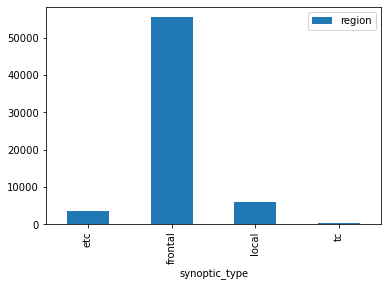

In [52]:
import matplotlib.pyplot as plt
storm_type_all2.groupby(['synoptic_type']).count().plot(kind='bar', y = 'region')
plt.show()

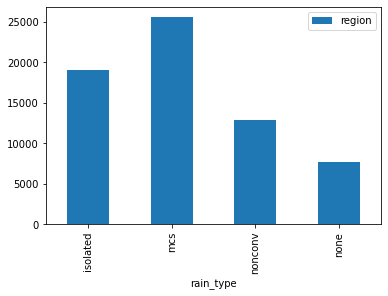

In [53]:
import matplotlib.pyplot as plt
storm_type_all2.groupby(['rain_type']).count().plot(kind='bar', y = 'region')
plt.show()

### use below to double-check that algorithm works correctly

In [16]:
front_mcs = np.where((tc_merge['fronts']==1.0) & (tc_merge['mcs']==1.0))
front_isolated = np.where((tc_merge['fronts']==1.0) & (tc_merge['isolated']==1.0) & (tc_merge['mcs']==0.0))
front_strat = np.where((tc_merge['fronts']==1.0) & (tc_merge['isolated']==0.0) & (tc_merge['mcs']==0.0) & (tc_merge['nonconv']==1.0))
front_norain = np.where((tc_merge['fronts']==1.0) & (tc_merge['isolated']==0.0) & (tc_merge['nonconv']==0.0) & (tc_merge['mcs']==0.0))

In [17]:
mcs_nofront = np.where((tc_merge['fronts']==0.0) & (tc_merge['mcs']==1.0))
isolated_nofront = np.where((tc_merge['fronts']==0.0) & (tc_merge['isolated']==1.0) & (tc_merge['mcs']==0.0))
strat_nofront = np.where((tc_merge['fronts']==0.0) & (tc_merge['isolated']==0.0) & (tc_merge['mcs']==0.0) & (tc_merge['nonconv']==1.0))

In [20]:
print(len(mcs_nofront[0]))
print(len(front_mcs[0]))

1265
24315


In [216]:
etc = np.where((tc_merge['etc']==1.0))
fronts = np.where((tc_merge['fronts']==1.0))
etc_front = np.where((tc_merge['fronts']==1.0) & (tc_merge['etc']==1.0))
etc_nofront = np.where((tc_merge['fronts']==0.0) & (tc_merge['etc']==1.0))
etc_nofront_noprecip = np.where((tc_merge['fronts']==0.0) & (tc_merge['etc']==1.0) & (tc_merge['isolated']==0.0) & (tc_merge['nonconv']==0.0) & (tc_merge['mcs']==0.0))

In [213]:
etc_front_mcs = np.where((tc_merge['fronts']==1.0) & (tc_merge['etc']==1.0) & (tc_merge['mcs']==1.0))
etc_nofront_mcs = np.where((tc_merge['fronts']==0.0) & (tc_merge['etc']==1.0) & (tc_merge['mcs']==1.0))
etc_nofront_iso = np.where((tc_merge['fronts']==0.0) & (tc_merge['etc']==1.0) & (tc_merge['mcs']==00.0) & (tc_merge['isolated']==1.0))
etc_nofront_strat = np.where((tc_merge['fronts']==0.0) & (tc_merge['etc']==1.0) & (tc_merge['mcs']==00.0) & (tc_merge['isolated']==0.0) & (tc_merge['nonconv']==1.0))

In [209]:
print(len(fronts[0]))
print(len(etc_front[0]))

56495
22335


In [219]:
print(len(etc[0]))
print(len(etc_front[0]))
print(len(etc_nofront[0]))
print(len(etc_nofront_noprecip[0]))

26008
22335
3673
1090


In [215]:
print(len(etc_front_mcs[0]))
print(len(etc_nofront_mcs[0]))
print(len(etc_nofront_iso[0]))
print(len(etc_nofront_strat[0]))
#print(etc_nofront_mcs[0])

11063
401
1162
1020
